<a href="https://colab.research.google.com/github/descartesmbogning/Deciphering_Bacteriophage_Revolution/blob/main/Patent_TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

import spacy
import codecs
import re
from wordcloud import STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from nltk.stem.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/patent_phage_lens_12072023.csv')
pd.set_option('display.max_columns', None)
print(len(df))
df.head()

6427


,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
0,6343,FR,A1,FR 2878165 A1,088-886-194-310-021,26/05/2006,2006,FR 0412364 A,22/11/2004,FR 0412364 A,22/11/2004,"New (mutant) netrin-4, netrin-1, netrin-3, ant...",(Mutant) netrin-4 protein (I) comprising at le...,CENTRE NAT RECH SCIENT;;I V S INST DES VAISSEA...,PLOUET JEAN;;ALEMANY MONICA,NaN,https://lens.org/088-886-194-310-021,Patent Application,no,1,7,1,21,0,A61K38/18;;A61P9/00;;A61P19/00;;A61P25/00,A61K38/17;;A61K39/395;;A61K48/00;;A61P9/00;;A6...,NaN,1,1,085-906-838-714-934,11038171;;pmc2192657;;10.1083/jcb.151.2.221,"KOCH M ET AL: ""A NOVEL MEMBER OF THE NETRIN FA...",DISCONTINUED
1,4170,EP,A2,EP 0174810 A2,114-080-007-142-359,19/03/1986,1986,EP 85306331 A,05/09/1985,CA 489897 A;;GB 8422819 A,10/09/1984,Multidrug resistance in mammalian cell lines a...,@ A method for isolating a cDNA specific for P...,HSC RES DEV CORP,RIORDAN JOHN R,HSC RESEARCH DEVELOPMENT CORPORATION (1993-03-24),https://lens.org/114-080-007-142-359,Patent Application,yes,0,31,6,10,0,C07K14/705;;C12N15/65;;C12N15/65;;C07K14/705,C07K14/705;;C12N1/21;;C12N15/65,NaN,0,0,NaN,NaN,NaN,EXPIRED
2,4522,EP,A3,EP 0192033 A3,145-504-884-019-37X,04/05/1988,1988,EP 86100279 A,10/01/1986,US 69200185 A,14/01/1985,CHLAMYDIA MAJOR OUTER MEMBRANE PROTEIN,@ Methods and compositions are provided for th...,CHIRON CORP;;WASHINGTON RES FOUND,"AGABIAN, NINA;;STEPHENS, RICHARD;;KUO, CHO-CHO...",CHIRON CORPORATION (1999-10-13);;CHIRON CORPOR...,https://lens.org/145-504-884-019-37X,Search Report,yes,2,0,7,10,2,A61K39/00;;C12Q1/689;;C07K14/295;;C07K2319/00;...,A61K39/00;;C07K14/295;;C12Q1/68;;G01N33/569,NaN,5,4,010-400-221-345-21X;;015-638-157-208-094;;030-...,pmc263342;;6469350;;10.1128/iai.45.3.637-641.1...,"INFECTION AND IMMUNITY, vol. 45, no. 3, Septem...",EXPIRED
3,2680,WO,A1,WO 2007/083793 A1,147-331-231-570-922,26/07/2007,2007,JP 2007050890 W,22/01/2007,JP 2006014314 A,23/01/2006,PANNING METHOD UTILIZING PHOTOREACTIVE GROUP A...,[PROBLEMS] To provide a method for ensuring th...,UNIV TOYAMA NAT UNIV CORP;;HATANAKA YASUMARU;;...,HATANAKA YASUMARU;;SADAKANE YUTAKA,NaN,https://lens.org/147-331-231-570-922,Patent Application,yes,1,2,2,2,4,C07D229/02;;G01N33/582;;G01N33/554,G01N33/53;;C07D229/02;;G01N33/15;;G01N33/543;;...,NaN,2,1,016-994-266-998-256,10.2174/1568026023394182;;11944820,"HATANAKA Y. ET AL.: ""Photoaffinity Labeling in...",PENDING
4,111,WO,A1,WO 2007/114139 A1,148-164-161-664-368,11/10/2007,2007,JP 2007056579 W,28/03/2007,JP 2006105143 A,06/04/2006,PHAGE DISPLAY BY NOVEL FILAMENTOUS BACTERIOPHAGE,[PROBLEMS] To provide a phage display vector w...,UCHIYAMA FUMIAKI,UCHIYAMA FUMIAKI,NaN,https://lens.org/148-164-161-664-368,Patent Application,yes,1,0,5,5,38,C07K14/005;;C12N15/1037;;C12N2795/14122;;C12N1...,C12N15/09;;C07K14/005;;C12N1/21;;C12N7/00;;C12...,NaN,24,22,050-417-296-901-112;;051-984-368-264-261;;058-...,16277371;;10.1021/cr000261r;;10.1006/jmbi.1999...,"KEHOE J.W. ET AL.: ""Filamentous phage display ...",PENDING


In [ ]:
## Convert 'Publication Year' to integers
df['Publication Year'] = df['Publication Year'].astype(int)

# Filter based on 'Publication Year' column
df = df[df['Publication Year'] >= 2003]
len(df)

5145

In [ ]:
df = df[(~pd.isnull(df['Abstract'])) & (~pd.isnull(df['Title']))]
len(df)

5145

In [ ]:
df = df.set_index(['Lens ID','Publication Year'])
df

,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
088-886-194-310-021,2006,6343,FR,A1,FR 2878165 A1,26/05/2006,FR 0412364 A,22/11/2004,FR 0412364 A,22/11/2004,"New (mutant) netrin-4, netrin-1, netrin-3, ant...",(Mutant) netrin-4 protein (I) comprising at le...,CENTRE NAT RECH SCIENT;;I V S INST DES VAISSEA...,PLOUET JEAN;;ALEMANY MONICA,NaN,https://lens.org/088-886-194-310-021,Patent Application,no,1,7,1,21,0,A61K38/18;;A61P9/00;;A61P19/00;;A61P25/00,A61K38/17;;A61K39/395;;A61K48/00;;A61P9/00;;A6...,NaN,1,1,085-906-838-714-934,11038171;;pmc2192657;;10.1083/jcb.151.2.221,"KOCH M ET AL: ""A NOVEL MEMBER OF THE NETRIN FA...",DISCONTINUED
147-331-231-570-922,2007,2680,WO,A1,WO 2007/083793 A1,26/07/2007,JP 2007050890 W,22/01/2007,JP 2006014314 A,23/01/2006,PANNING METHOD UTILIZING PHOTOREACTIVE GROUP A...,[PROBLEMS] To provide a method for ensuring th...,UNIV TOYAMA NAT UNIV CORP;;HATANAKA YASUMARU;;...,HATANAKA YASUMARU;;SADAKANE YUTAKA,NaN,https://lens.org/147-331-231-570-922,Patent Application,yes,1,2,2,2,4,C07D229/02;;G01N33/582;;G01N33/554,G01N33/53;;C07D229/02;;G01N33/15;;G01N33/543;;...,NaN,2,1,016-994-266-998-256,10.2174/1568026023394182;;11944820,"HATANAKA Y. ET AL.: ""Photoaffinity Labeling in...",PENDING
148-164-161-664-368,2007,111,WO,A1,WO 2007/114139 A1,11/10/2007,JP 2007056579 W,28/03/2007,JP 2006105143 A,06/04/2006,PHAGE DISPLAY BY NOVEL FILAMENTOUS BACTERIOPHAGE,[PROBLEMS] To provide a phage display vector w...,UCHIYAMA FUMIAKI,UCHIYAMA FUMIAKI,NaN,https://lens.org/148-164-161-664-368,Patent Application,yes,1,0,5,5,38,C07K14/005;;C12N15/1037;;C12N2795/14122;;C12N1...,C12N15/09;;C07K14/005;;C12N1/21;;C12N7/00;;C12...,NaN,24,22,050-417-296-901-112;;051-984-368-264-261;;058-...,16277371;;10.1021/cr000261r;;10.1006/jmbi.1999...,"KEHOE J.W. ET AL.: ""Filamentous phage display ...",PENDING
161-684-752-020-329,2004,3085,JP,A,JP 2004097032 A,02/04/2004,JP 2002260418 A,05/09/2002,JP 2002260418 A,05/09/2002,METHOD FOR MONITORING BACTERIUM UTILIZING CHIT...,<P>PROBLEM TO BE SOLVED: To develop a method f...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/161-684-752-020-329,Patent Application,no,0,1,2,2,0,Y02A50/30,C12N15/09;;C12Q1/04;;C12Q1/34,NaN,0,0,NaN,NaN,NaN,EXPIRED
089-102-410-621-069,2004,3892,JP,A,JP 2004099465 A,02/04/2004,JP 2002260419 A,05/09/2002,JP 2002260419 A,05/09/2002,METHOD FOR CONTROLLING INSECT PEST WITH ALGINA...,<P>PROBLEM TO BE SOLVED: To develop a new defo...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/089-102-410-621-069,Patent Application,no,0,0,2,2,0,NaN,C12N15/09;;A01N25/28;;A01N63/00;;C12N1/20;;C12...,NaN,0,0,NaN,NaN,NaN,EXPIRED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179-151-089-030-564,2019,6156,CZ,U1,CZ 33381 U1,12/11/2019,CZ 201936608 U,09/09/2019,CZ 201936608 U,09/09/2019,System for preparing samples and identifying a...,.,UNIV MASARYKOVA,PANTŮČEK ROMAN;;ŠTVERÁKOVÁ DANA;;ŠEDO ONDREJ;;...,NaN,https://lens.org/179-151-089-030-564,Limited Patent,no,0,0,1,1,0,C12N7/02;;C12Q1/70,C12Q1/70;;C12N7/02,NaN,0,0,NaN,NaN,NaN,ACTIVE
014-594-233-943-253,2020,6024,CZ,U1,CZ 33918 U1,14/04/2020,CZ 202037223 U,06/02/2020,CZ 202037223 U,06/02/2020,Test kit to determine the antimicrobial biolog...,.,MB PHARMA S R O,MOŠA MAREK;;BENEŠÍK MARTIN,NaN,https://lens.org/014-594-233-943-253,Limited Patent,no,0,1,1,1,0,C12N1/205;;C12Q1/70;;C12R2001/445,C12Q1/70;;C12R1/44,NaN,0,0,NaN,

In [ ]:
data = [str(df['Title'][i])+str(df['Abstract'][i]) for i in df.index] #Title and Abstract
len(data)

5145

In [ ]:
#data

In [ ]:
!python -m spacy download en_core_web_md

2023-09-15 17:40:49.341417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
s = set(STOPWORDS)
sw = stopwords.words('english')
sw += s
sw.append ('amp')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Read the texts and remove the stopwords :
#Build the text list:
txt = []
idx = []
t1 = ''
t2 = []
for i in range(len(data)):
        t1 = str(data[i]).lower()
 #       t1 = re.sub ('#','',t1)
        #t1 = re.sub ('.','',t1)
 #       t1 = re.sub (',','',t1)
 #       t1 = re.sub ("'",'',t1)
#        t1 = t1.replace('.','')
        t2 = t1.split()
        t1 = ''
        for item2 in t2:
            if item2 not in sw:
                t1 += item2
                t1 += ' '
        if t1[:-1] not in txt and t1[:-1] != '':
            txt.append (t1[:-1])
            idx.append (i)
len (txt)

5108

In [ ]:
#txt

In [ ]:
print(type(txt))

<class 'list'>


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Assume df is your original DataFrame
# Remove rows where either 'Abstract' or 'Title' is null
df = df.dropna(subset=['Abstract', 'Title'])

# Generate the data list combining 'Title' and 'Abstract'
data = [str(df['Title'].iloc[i]) + str(df['Abstract'].iloc[i]) for i in range(len(df))]

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

# Generate a list of stopwords
s = set(STOPWORDS)
sw = set(stopwords.words('english'))
sw |= s
sw.add('amp')

# Initialize a list to store cleaned texts
cleaned_texts = []

# Text preprocessing
for text in data:
    words = text.lower().split()
    cleaned_words = [word for word in words if word not in sw]
    cleaned_text = ' '.join(cleaned_words)
    cleaned_texts.append(cleaned_text)

# Add the cleaned texts back to the original DataFrame
df['Cleaned_Text'] = cleaned_texts
len(df)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5145

In [ ]:
# Drop rows where 'Cleaned_Text' is null
df_filtered = df.dropna(subset=['Cleaned_Text'])

# Keep only the rows with unique 'Cleaned_Text'
df_filtered = df_filtered.drop_duplicates(subset=['Cleaned_Text'])
df_filtered

,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
088-886-194-310-021,2006,6343,FR,A1,FR 2878165 A1,26/05/2006,FR 0412364 A,22/11/2004,FR 0412364 A,22/11/2004,"New (mutant) netrin-4, netrin-1, netrin-3, ant...",(Mutant) netrin-4 protein (I) comprising at le...,CENTRE NAT RECH SCIENT;;I V S INST DES VAISSEA...,PLOUET JEAN;;ALEMANY MONICA,NaN,https://lens.org/088-886-194-310-021,Patent Application,no,1,7,1,21,0,A61K38/18;;A61P9/00;;A61P19/00;;A61P25/00,A61K38/17;;A61K39/395;;A61K48/00;;A61P9/00;;A6...,NaN,1,1,085-906-838-714-934,11038171;;pmc2192657;;10.1083/jcb.151.2.221,"KOCH M ET AL: ""A NOVEL MEMBER OF THE NETRIN FA...",DISCONTINUED,"new (mutant) netrin-4, netrin-1, netrin-3, ant..."
147-331-231-570-922,2007,2680,WO,A1,WO 2007/083793 A1,26/07/2007,JP 2007050890 W,22/01/2007,JP 2006014314 A,23/01/2006,PANNING METHOD UTILIZING PHOTOREACTIVE GROUP A...,[PROBLEMS] To provide a method for ensuring th...,UNIV TOYAMA NAT UNIV CORP;;HATANAKA YASUMARU;;...,HATANAKA YASUMARU;;SADAKANE YUTAKA,NaN,https://lens.org/147-331-231-570-922,Patent Application,yes,1,2,2,2,4,C07D229/02;;G01N33/582;;G01N33/554,G01N33/53;;C07D229/02;;G01N33/15;;G01N33/543;;...,NaN,2,1,016-994-266-998-256,10.2174/1568026023394182;;11944820,"HATANAKA Y. ET AL.: ""Photoaffinity Labeling in...",PENDING,panning method utilizing photoreactive group k...
148-164-161-664-368,2007,111,WO,A1,WO 2007/114139 A1,11/10/2007,JP 2007056579 W,28/03/2007,JP 2006105143 A,06/04/2006,PHAGE DISPLAY BY NOVEL FILAMENTOUS BACTERIOPHAGE,[PROBLEMS] To provide a phage display vector w...,UCHIYAMA FUMIAKI,UCHIYAMA FUMIAKI,NaN,https://lens.org/148-164-161-664-368,Patent Application,yes,1,0,5,5,38,C07K14/005;;C12N15/1037;;C12N2795/14122;;C12N1...,C12N15/09;;C07K14/005;;C12N1/21;;C12N7/00;;C12...,NaN,24,22,050-417-296-901-112;;051-984-368-264-261;;058-...,16277371;;10.1021/cr000261r;;10.1006/jmbi.1999...,"KEHOE J.W. ET AL.: ""Filamentous phage display ...",PENDING,phage display novel filamentous bacteriophage[...
161-684-752-020-329,2004,3085,JP,A,JP 2004097032 A,02/04/2004,JP 2002260418 A,05/09/2002,JP 2002260418 A,05/09/2002,METHOD FOR MONITORING BACTERIUM UTILIZING CHIT...,<P>PROBLEM TO BE SOLVED: To develop a method f...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/161-684-752-020-329,Patent Application,no,0,1,2,2,0,Y02A50/30,C12N15/09;;C12Q1/04;;C12Q1/34,NaN,0,0,NaN,NaN,NaN,EXPIRED,method monitoring bacterium utilizing chitinou...
089-102-410-621-069,2004,3892,JP,A,JP 2004099465 A,02/04/2004,JP 2002260419 A,05/09/2002,JP 2002260419 A,05/09/2002,METHOD FOR CONTROLLING INSECT PEST WITH ALGINA...,<P>PROBLEM TO BE SOLVED: To develop a new defo...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/089-102-410-621-069,Patent Application,no,0,0,2,2,0,NaN,C12N15/09;;A01N25/28;;A01N63/00;;C12N1/20;;C12...,NaN,0,0,NaN,NaN,NaN,EXPIRED,method controlling insect pest alginate microb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179-151-089-030-564,2019,6156,CZ,U1,CZ 33381 U1,12/11/2019,CZ 201936608 U,09/09/2019,CZ 201936608 U,09/09/2019,System for preparing samples and identifying a...,.,UNIV MASARYKOVA,PANTŮČEK ROMAN;;ŠTVERÁKOVÁ DANA;;ŠEDO ONDREJ;;...,NaN,https://lens.org/179-151-089-030-564,Limited Patent,no,0,0,1,1,0,C12N7/02;;C12Q1/70,C12Q1/70;;C12N7/02,NaN,0,0,NaN,NaN,NaN,ACTIVE,system preparing samples identifying least one...
014-594-233-943-253,

In [ ]:
text = df['Cleaned_Text'].tolist()
text

['new (mutant) netrin-4, netrin-1, netrin-3, anti-idiotypic netrin-4 antibodies, fab fragments nucleotide sequences useful preventing treating tumoral non-tumoral disorders (of angiogenesis)(mutant) netrin-4 protein (i) comprising least 230 amino acids seq id. nos 522 524, fragment, derivative homologue, new. (mutant) netrine-4 protein (i) comprising contains one following sequences; seq id no. 522 524, fragment 522/524 anti-angiogenic activity and/or perictye activation activity, fragment comprises 40 450 amino acids, preferably 40 230 amino acids represented seq id no: 2q, q variant 187 248 seq id 526 528. included sequences substitutions, suppression addition one amino acids providing sequences anti-angiogenic perictye activation activity. active homologues included least approximiately 50 % sequence identity region amino acids 261 515 seq id no: 522. sequence information fully defined specification. independent claims included for: (1) nucleotide sequence (ii) encoding proteins (i)

In [ ]:
def lemmatization (texts, allowed_postags=['NOUN','ADJ','VERB']):
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append (token.lemma_)
        final = " ".join(new_text)
        texts_out.append (final)
    return (texts_out)

In [ ]:
txt = lemmatization (txt)

In [ ]:
# Tokenization
def tokenize (texts):
    tokens = [word for word in nltk.word_tokenize(texts) if len(word) > 2]
    return tokens

In [ ]:
tok = []
for item in txt:
  tok.append (tokenize (item))

In [ ]:
vectorizer_tf = TfidfVectorizer (tokenizer=tokenize, stop_words='english', max_df=0.75, min_df=50,  use_idf=False, norm=None) #max_features=10000,

In [ ]:
#df

In [ ]:
df1 = pd.DataFrame(data={'Text':txt})
tf_vectors = vectorizer_tf.fit_transform (df1['Text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
#data.to_frame()

In [ ]:
df1

,Text
0,new mutant anti - idiotypic antibody fragment ...
1,pan method utilize photoreactive group kit pro...
2,phage display novel filamentous bacteriophage[...
3,method monitor bacterium utilize chitinous sub...
4,method control insect pest alginate microbead ...
...,...
5103,system prepare sample identify least bacteriop...
5104,test determine antimicrobial biological activi...
5105,parenteral use bacterial phage associate lyse ...
5106,use bacterial phage associate lyse enzyme prop...


In [ ]:
import pickle
with open('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/vectorizer_tf_patent.pk', 'wb') as f:
     pickle.dump(vectorizer_tf, f)

In [ ]:
import scipy.sparse
scipy.sparse.save_npz('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/tf_vectors_patent.npz', tf_vectors)

In [ ]:
# Save this model with 20 topics:
import pickle
with open("/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/vectorizer_tf_patent.pk","rb") as f:
    vectorizer_tf = pickle.load (f)

import scipy.sparse
tf_vectors = scipy.sparse.load_npz('/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/tf_vectors_patent.npz')

# Finding the Best Number of Topics

In [ ]:
!pip install tmtoolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=c24f030e88d7ce831c50d2271748eaadeb94c942e94c8a42d10c2aa2488b0324
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre


In [ ]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from statistics import mean
from sklearn.metrics import jaccard_score

In [ ]:
coh0 = 0
js0 = 100
ppx0 = 100
num = 1
for topic_num in range (5, 30):
  lda = decomposition.LatentDirichletAllocation (n_components=topic_num, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
  # n_components is the number of topics

  w1 = lda.fit_transform (tf_vectors)
  #h1 = lda.components_

  ppx = lda.perplexity(w1,  sub_sampling=False)

  coh = mean (metric_coherence_gensim(measure='c_v', top_n=30, topic_word_distrib=lda.components_, vocab=np.array([x for x in vectorizer_tf.vocabulary_.keys()]), texts=tok))

  l = len (lda.components_)
  n = 0
  js = 0
  for i in range(0, l-1):
    topic1 = [1 if x>1 else 0 for x in lda.components_[i]]
    for j in range(i+1, l):
      topic2 = [1 if x>1 else 0 for x in lda.components_[j]]
      js += jaccard_score (topic1, topic2)
      n += 1
  js /= n

  if js > js0 and coh < coh0 and ppx > ppx0:
    pass
  else:
    num = topic_num
    js0 = js
    coh0 = coh
    ppx0 = ppx

  print ('num_topic: ', topic_num, 'Coherence: ', coh, 'Jaccard: ', js, 'Perplexity: ', ppx)
#print ('BEST: ', 'num_topic: ', num, 'Coherence: ', coh0, 'Jaccard: ', js0, 'Perplexity: ', ppx0)

num_topic:  5 Coherence:  0.3108665230505656 Jaccard:  0.5289914192228857 Perplexity:  17984.236646838803
num_topic:  6 Coherence:  0.32087704024081715 Jaccard:  0.4615886832606044 Perplexity:  22207.375932724557
num_topic:  7 Coherence:  0.3267058421249324 Jaccard:  0.42447409081641496 Perplexity:  37037.84018243344
num_topic:  8 Coherence:  0.34431825526688253 Jaccard:  0.3680336473888281 Perplexity:  38428.386485963485
num_topic:  9 Coherence:  0.31936696036819323 Jaccard:  0.34307143064908413 Perplexity:  46015.56442912667
num_topic:  10 Coherence:  0.32213571083033077 Jaccard:  0.3265723540064453 Perplexity:  110684.65574950636
num_topic:  11 Coherence:  0.33291721604131225 Jaccard:  0.3213762686191022 Perplexity:  114314.54251754786
num_topic:  12 Coherence:  0.33425632014067774 Jaccard:  0.2876168389259063 Perplexity:  113724.47483893906
num_topic:  13 Coherence:  0.32836353706931226 Jaccard:  0.2772779361251824 Perplexity:  153945.61024117155
num_topic:  14 Coherence:  0.328574

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


num_topic:  27 Coherence:  0.33421700061807935 Jaccard:  0.13978840195453063 Perplexity:  2624011.7266943404


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


num_topic:  28 Coherence:  0.33069126540438337 Jaccard:  0.131587157472573 Perplexity:  2669800.951453526
num_topic:  29 Coherence:  0.3250647919147073 Jaccard:  0.1425050239126077 Perplexity:  5149477.36941325


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Topic Modeling

In [ ]:
!pip install pyLDAvis==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
lda = decomposition.LatentDirichletAllocation (n_components=8, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
# n_components is the number of topics

w1 = lda.fit_transform (tf_vectors)
h1 = lda.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
with open("/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent.pk","wb") as f1:
    pickle.dump (lda, f1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
lda = decomposition.LatentDirichletAllocation (n_components=8, learning_method='online', learning_offset=50, n_jobs=-1, random_state=111)
with open("/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/lda_patent.pk","rb") as f1:
    lda = pickle.load (f1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(lda, tf_vectors, vectorizer_tf, mds='tsne')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


What did I do to make this work?

I installed pyLDAvis, but didn't import it!

I went to usr/local/lib/python3.10/dist-packages/pyLDAvis/sklearn.py
and changed get_feature_names() to get_feature_names_out()

saved it!
Then imported pyLDAvis and pyLDAvis.sklearn

In [ ]:
w1 = lda.transform (tf_vectors)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
w1.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5108, 8)

In [ ]:
text = []
topic = []
probabilit = []
for i in range(len(idx)):
  text.append (str(data[idx[i]]))
  t = np.argmax (w1[i,:])
  topic.append (t)
  probabilit.append (w1[i,t])
probabilities = pd.DataFrame (data= {'Text':text,'Topic':topic,'Probability':probabilit})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Topic:','Number:')
for i in range(8):
  print('topic',i,'    ',list(probabilities['Topic']).count(i))

Topic: Number:
topic 0      266
topic 1      391
topic 2      1310
topic 3      596
topic 4      260
topic 5      1512
topic 6      175
topic 7      598


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# topic similarity matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## cosine_similarity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


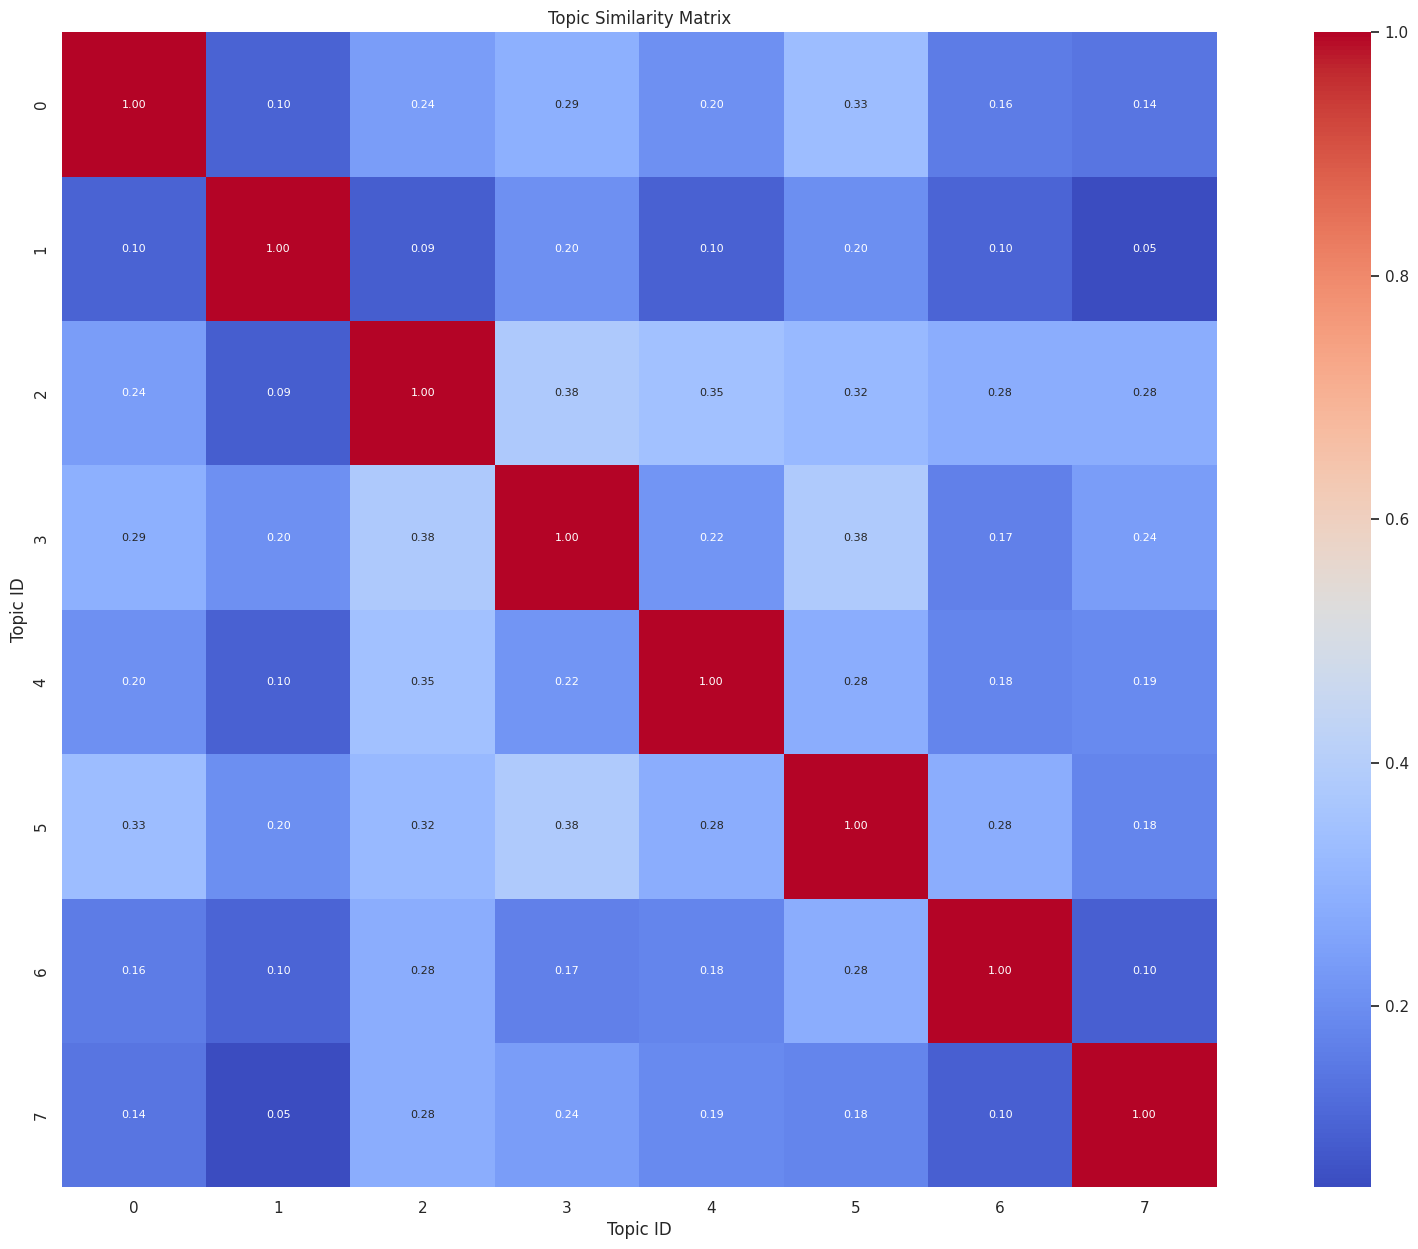

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Create a heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    topic_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 8},
)
plt.title("Topic Similarity Matrix")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_patent.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


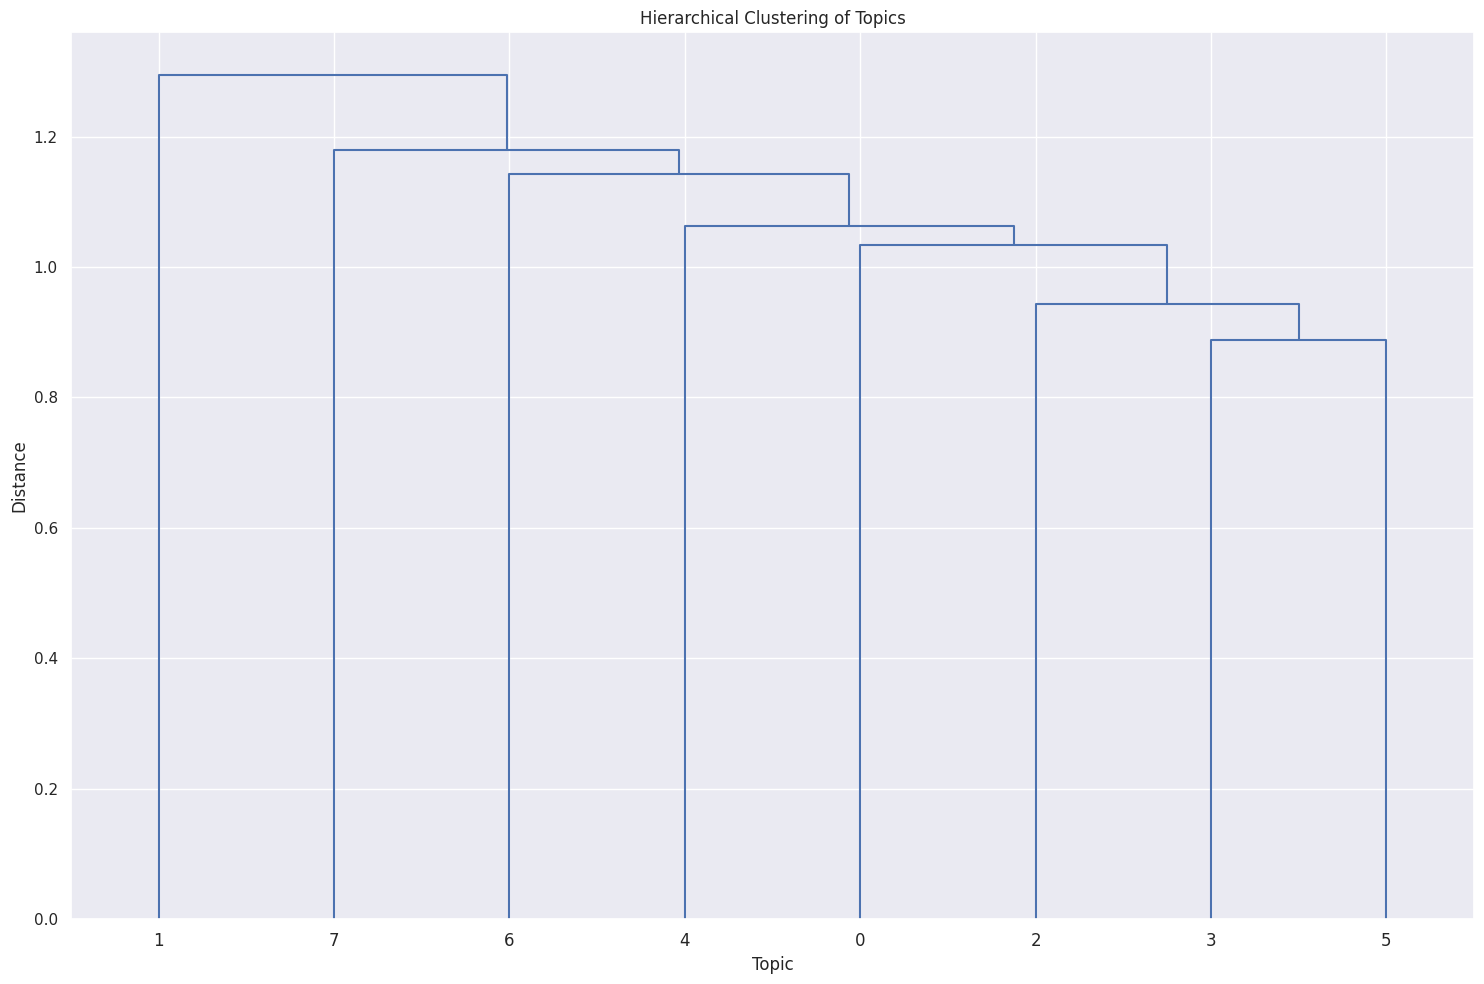

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

# Assuming lda_model is your trained LDA model
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Compute the cosine similarity matrix
topic_similarity_matrix = cosine_similarity(topic_word_distributions)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - topic_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics")
plt.xlabel("Topic")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_patent.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## jaccard_similarity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


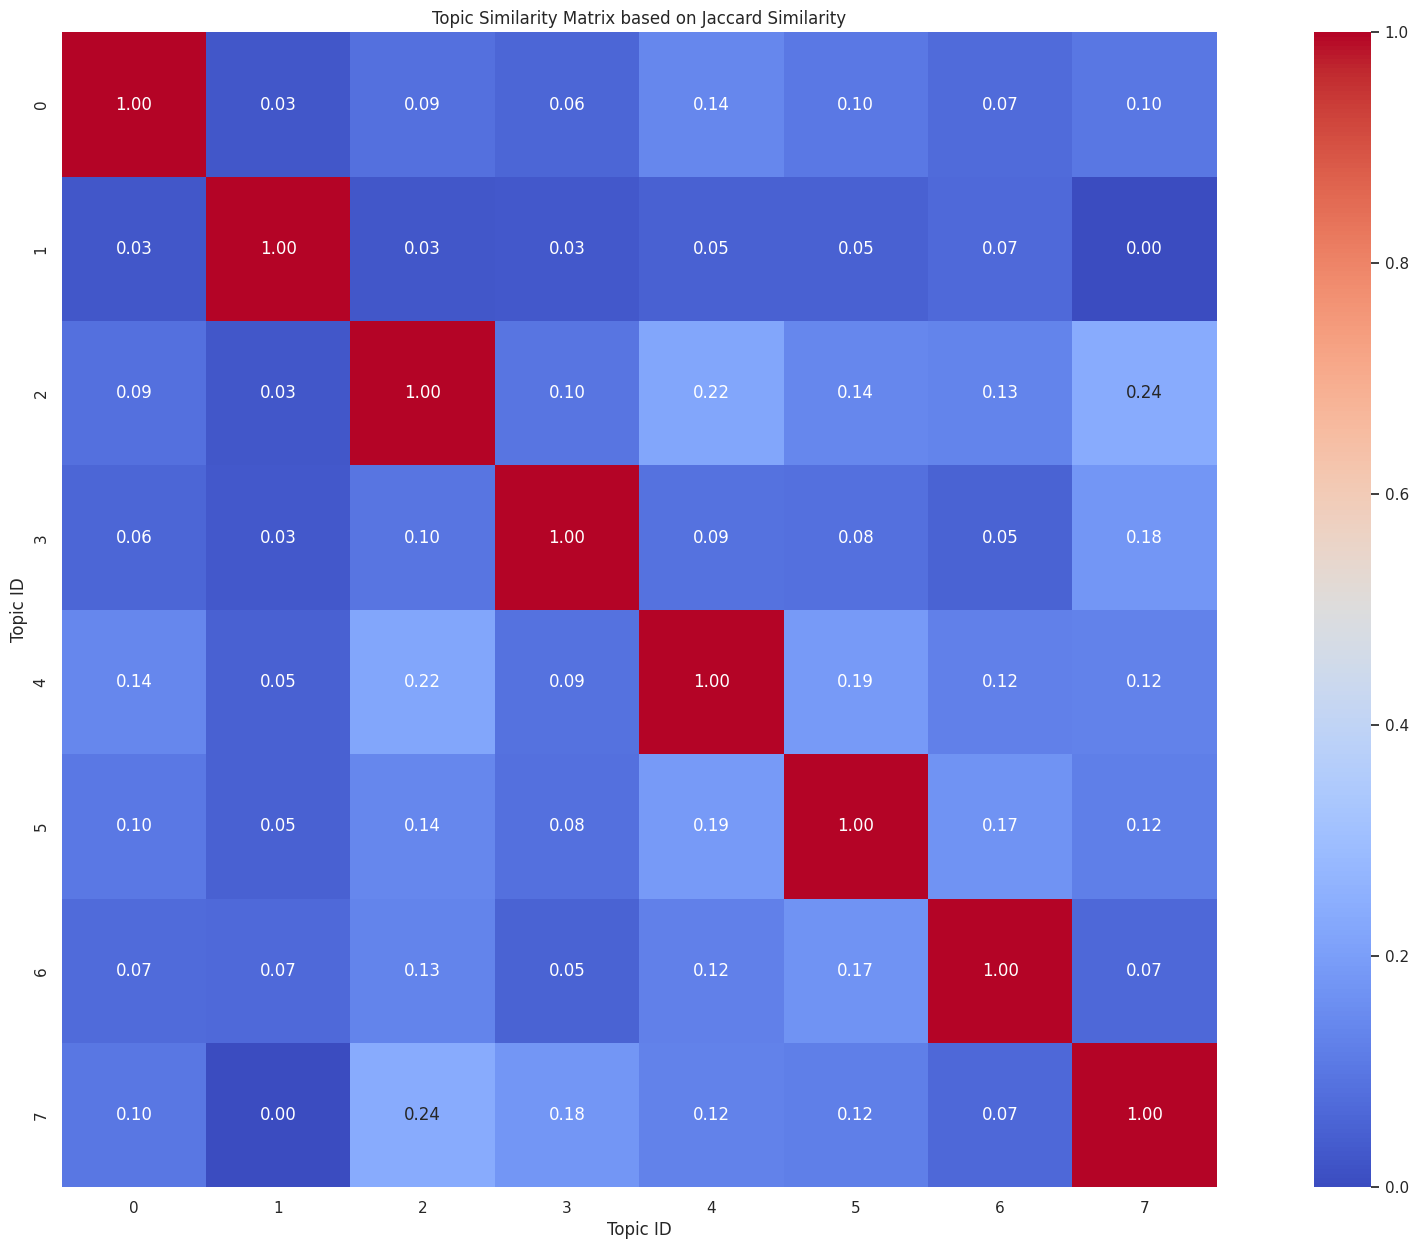

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation

def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
# Normalize the topic-word distribution
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Number of topics
n_topics = lda.components_.shape[0]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)


# Plot Heatmap
plt.figure(figsize=(25, 15))
sns.set(font_scale=1)
sns.heatmap(
    jaccard_similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 12}
)
plt.title("Topic Similarity Matrix based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")

# Save the figure
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_similarity_matrix_jaccard_PATENT_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-f84d0efbb40c>:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - jaccard_similarity_matrix, method="average")


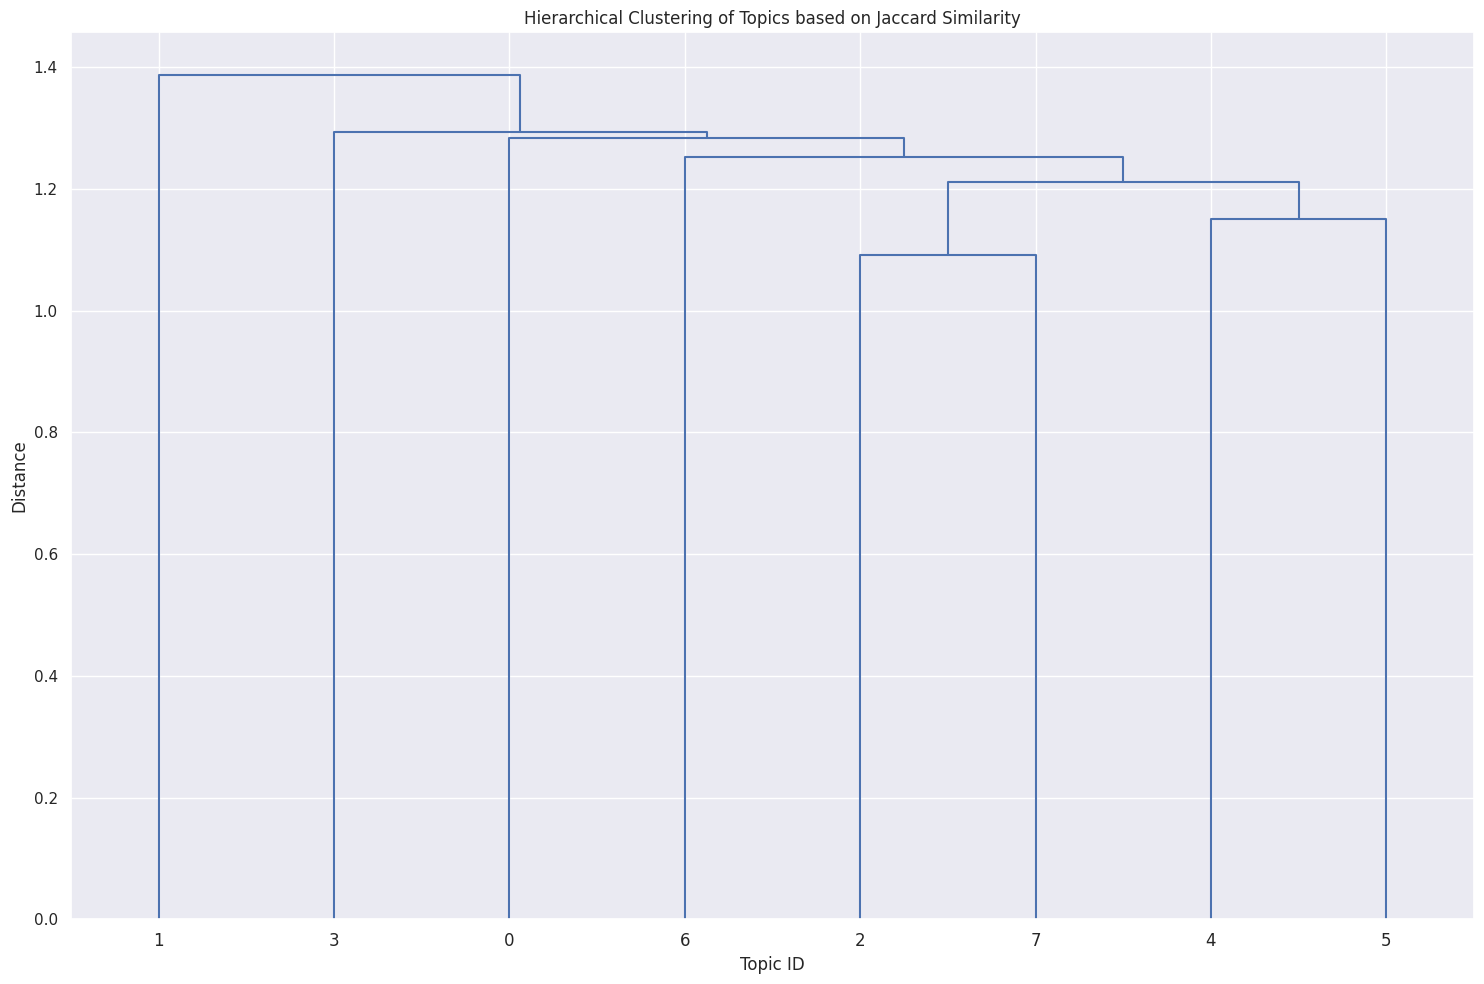

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import LatentDirichletAllocation

# Define Jaccard Similarity function
def jaccard_similarity(vector1, vector2, threshold=0.01):
    set1 = set(np.where(vector1 > threshold)[0])
    set2 = set(np.where(vector2 > threshold)[0])
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    if union == 0:
        return 0
    else:
        return intersection / union


# Assuming lda is your trained LDA model
n_topics = lda.components_.shape[0]
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

# Create Jaccard Similarity matrix
jaccard_similarity_matrix = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        jaccard_similarity_matrix[i, j] = jaccard_similarity(topic_word_distributions[i, :], topic_word_distributions[j, :], threshold=0.01)

# Perform hierarchical clustering
linkage_matrix = linkage(1 - jaccard_similarity_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, color_threshold=0.5)
plt.title("Hierarchical Clustering of Topics based on Jaccard Similarity")
plt.xlabel("Topic ID")
plt.ylabel("Distance")
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_clustering_dendrogram_jaccard_PATENT_{n_topics}.png', dpi=600)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get_top_keywords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_top_keywords(lda_model, vectorizer, n_words=50):
    terms = vectorizer.get_feature_names_out()
    topic_keywords = []

    for topic_idx, topic in enumerate(lda.components_):
        top_keywords_idx = topic.argsort()[::-1][:n_words]
        top_keywords = [(terms[i], topic[i]) for i in top_keywords_idx]
        topic_keywords.append(top_keywords)

    return topic_keywords

top_keywords = get_top_keywords(lda, vectorizer_tf, n_words=50)

# To display the topics with their keywords and scores
with open(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/top_keywords_patent.txt", "w") as f:
    for idx, keywords in enumerate(top_keywords):
        f.write(f"Topic {idx}:\n")
        print(f"Topic {idx}:")
        for word, score in keywords:
            f.write(f"{word}, ")
            print(f"{word}", end=", ")
        f.write("\n\n")
        print("\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0:
detection, method, sample, detect, bacteriophage, use, test, invention, kit, reaction, probe, fluorescent, specific, microorganism, control, nano, base, positive, enzyme, result, identification, material, mixture, determine, biological, m13, label, signal, time, presence, phage, sensitivity, concentration, contain, carry, rapid, reagent, internal, assay, agent, amplification, relate, substrate, accord, primer, animal, sensor, cross, fragment, measure, 

Topic 1:
device, model, air, water, filter, utility, body, arrange, bacteriophage, plate, connect, provide, disclose, end, box, include, pipe, tank, equip, fix, set, use, layer, support, cover, shell, gas, inner, structure, surface, ion, tube, storage, disinfection, membrane, case, frame, rod, control, comprise, inlet, base, upper, second, outer, place, wall, form, purification, seal, 

Topic 2:
protein, phage, peptide, cell, method, gene, polypeptide, target, invention, bind, use, recombinant, display, expression, vector, prov

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Emergent topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

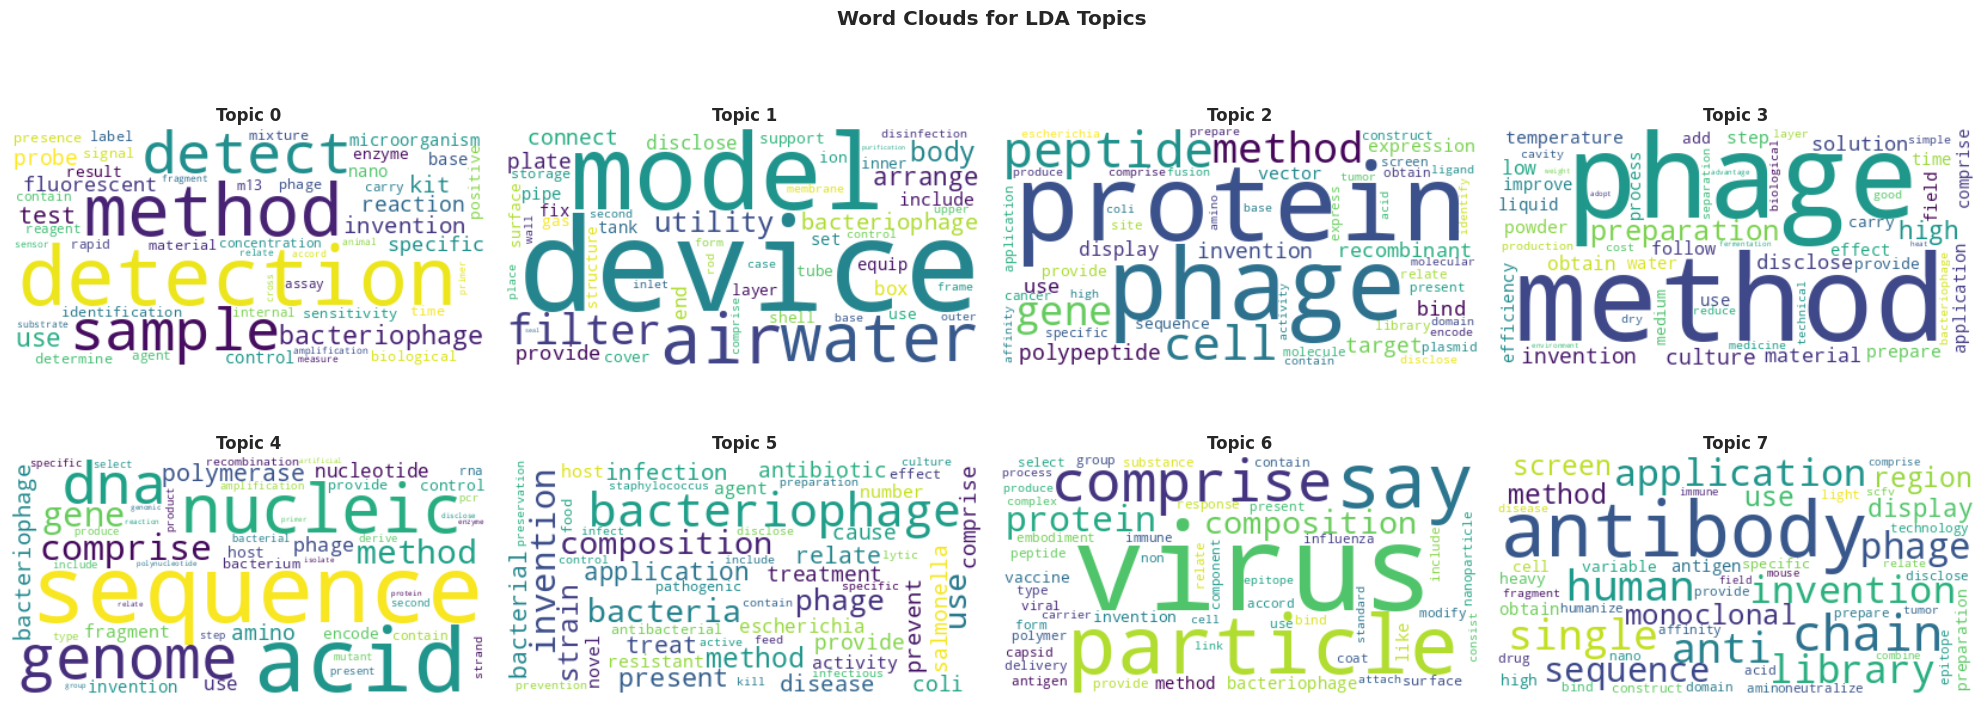

In [ ]:
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# Word Clouds for topics
def plot_wordcloud(lda, topic_id, ax, n_words=50):
    terms = vectorizer_tf.get_feature_names_out()
    word_probs = {terms[i]: prob for i, prob in enumerate(lda.components_[topic_id])}
    wc = WordCloud(background_color='white', max_words=n_words).generate_from_frequencies(word_probs)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_id}", fontweight='bold')  # Bold title for each subplot

# Assuming n_topics to be the number of topics you've chosen
n_topics = 8  # Make sure this matches the number of topics in lda_model

# Calculate the number of rows needed
n_rows = int(np.ceil(n_topics / 4))

fig, axes = plt.subplots(n_rows, 4, figsize=(20, 4 * n_rows))

# Flatten the array and truncate it to match the number of topics
axes_flat = axes.flatten()[:n_topics]

for ax, topic_id in zip(axes_flat, range(n_topics)):
    plot_wordcloud(lda, topic_id, ax)

# Remove extra subplots
for idx in range(n_topics, len(axes.flatten())):
    fig.delaxes(axes.flatten()[idx])

plt.suptitle("Word Clouds for LDA Topics", fontweight='bold')  # Bold main title
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/wordclouds_patent.png', dpi=600)  # Use raw string for path
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Attach Discovered Topic Labels to Original scholar publications

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_topics = lda.transform(tf_vectors)
final_topics.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5108, 8)

In [ ]:
df_filtered["Topic N°"] = final_topics.argmax(axis=1)
df_filtered.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text,Topic N°
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
088-886-194-310-021,2006,6343,FR,A1,FR 2878165 A1,26/05/2006,FR 0412364 A,22/11/2004,FR 0412364 A,22/11/2004,"New (mutant) netrin-4, netrin-1, netrin-3, ant...",(Mutant) netrin-4 protein (I) comprising at le...,CENTRE NAT RECH SCIENT;;I V S INST DES VAISSEA...,PLOUET JEAN;;ALEMANY MONICA,NaN,https://lens.org/088-886-194-310-021,Patent Application,no,1,7,1,21,0,A61K38/18;;A61P9/00;;A61P19/00;;A61P25/00,A61K38/17;;A61K39/395;;A61K48/00;;A61P9/00;;A6...,NaN,1,1,085-906-838-714-934,11038171;;pmc2192657;;10.1083/jcb.151.2.221,"KOCH M ET AL: ""A NOVEL MEMBER OF THE NETRIN FA...",DISCONTINUED,"new (mutant) netrin-4, netrin-1, netrin-3, ant...",4
147-331-231-570-922,2007,2680,WO,A1,WO 2007/083793 A1,26/07/2007,JP 2007050890 W,22/01/2007,JP 2006014314 A,23/01/2006,PANNING METHOD UTILIZING PHOTOREACTIVE GROUP A...,[PROBLEMS] To provide a method for ensuring th...,UNIV TOYAMA NAT UNIV CORP;;HATANAKA YASUMARU;;...,HATANAKA YASUMARU;;SADAKANE YUTAKA,NaN,https://lens.org/147-331-231-570-922,Patent Application,yes,1,2,2,2,4,C07D229/02;;G01N33/582;;G01N33/554,G01N33/53;;C07D229/02;;G01N33/15;;G01N33/543;;...,NaN,2,1,016-994-266-998-256,10.2174/1568026023394182;;11944820,"HATANAKA Y. ET AL.: ""Photoaffinity Labeling in...",PENDING,panning method utilizing photoreactive group k...,2
148-164-161-664-368,2007,111,WO,A1,WO 2007/114139 A1,11/10/2007,JP 2007056579 W,28/03/2007,JP 2006105143 A,06/04/2006,PHAGE DISPLAY BY NOVEL FILAMENTOUS BACTERIOPHAGE,[PROBLEMS] To provide a phage display vector w...,UCHIYAMA FUMIAKI,UCHIYAMA FUMIAKI,NaN,https://lens.org/148-164-161-664-368,Patent Application,yes,1,0,5,5,38,C07K14/005;;C12N15/1037;;C12N2795/14122;;C12N1...,C12N15/09;;C07K14/005;;C12N1/21;;C12N7/00;;C12...,NaN,24,22,050-417-296-901-112;;051-984-368-264-261;;058-...,16277371;;10.1021/cr000261r;;10.1006/jmbi.1999...,"KEHOE J.W. ET AL.: ""Filamentous phage display ...",PENDING,phage display novel filamentous bacteriophage[...,2
161-684-752-020-329,2004,3085,JP,A,JP 2004097032 A,02/04/2004,JP 2002260418 A,05/09/2002,JP 2002260418 A,05/09/2002,METHOD FOR MONITORING BACTERIUM UTILIZING CHIT...,<P>PROBLEM TO BE SOLVED: To develop a method f...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/161-684-752-020-329,Patent Application,no,0,1,2,2,0,Y02A50/30,C12N15/09;;C12Q1/04;;C12Q1/34,NaN,0,0,NaN,NaN,NaN,EXPIRED,method monitoring bacterium utilizing chitinou...,0
089-102-410-621-069,2004,3892,JP,A,JP 2004099465 A,02/04/2004,JP 2002260419 A,05/09/2002,JP 2002260419 A,05/09/2002,METHOD FOR CONTROLLING INSECT PEST WITH ALGINA...,<P>PROBLEM TO BE SOLVED: To develop a new defo...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/089-102-410-621-069,Patent Application,no,0,0,2,2,0,NaN,C12N15/09;;A01N25/28;;A01N63/00;;C12N1/20;;C12...,NaN,0,0,NaN,NaN,NaN,EXPIRED,method controlling insect pest alginate microb...,5


In [ ]:
# Save data to CSV and Pickle formats
df_filtered.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent.csv', index=False)
df_filtered.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_probability_patent.pkl')

df_filtered.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,,#,Jurisdiction,Kind,Display Key,Publication Date,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Extended Family Size,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Cleaned_Text,Topic N°
Lens ID,Publication Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
088-886-194-310-021,2006,6343,FR,A1,FR 2878165 A1,26/05/2006,FR 0412364 A,22/11/2004,FR 0412364 A,22/11/2004,"New (mutant) netrin-4, netrin-1, netrin-3, ant...",(Mutant) netrin-4 protein (I) comprising at le...,CENTRE NAT RECH SCIENT;;I V S INST DES VAISSEA...,PLOUET JEAN;;ALEMANY MONICA,NaN,https://lens.org/088-886-194-310-021,Patent Application,no,1,7,1,21,0,A61K38/18;;A61P9/00;;A61P19/00;;A61P25/00,A61K38/17;;A61K39/395;;A61K48/00;;A61P9/00;;A6...,NaN,1,1,085-906-838-714-934,11038171;;pmc2192657;;10.1083/jcb.151.2.221,"KOCH M ET AL: ""A NOVEL MEMBER OF THE NETRIN FA...",DISCONTINUED,"new (mutant) netrin-4, netrin-1, netrin-3, ant...",4
147-331-231-570-922,2007,2680,WO,A1,WO 2007/083793 A1,26/07/2007,JP 2007050890 W,22/01/2007,JP 2006014314 A,23/01/2006,PANNING METHOD UTILIZING PHOTOREACTIVE GROUP A...,[PROBLEMS] To provide a method for ensuring th...,UNIV TOYAMA NAT UNIV CORP;;HATANAKA YASUMARU;;...,HATANAKA YASUMARU;;SADAKANE YUTAKA,NaN,https://lens.org/147-331-231-570-922,Patent Application,yes,1,2,2,2,4,C07D229/02;;G01N33/582;;G01N33/554,G01N33/53;;C07D229/02;;G01N33/15;;G01N33/543;;...,NaN,2,1,016-994-266-998-256,10.2174/1568026023394182;;11944820,"HATANAKA Y. ET AL.: ""Photoaffinity Labeling in...",PENDING,panning method utilizing photoreactive group k...,2
148-164-161-664-368,2007,111,WO,A1,WO 2007/114139 A1,11/10/2007,JP 2007056579 W,28/03/2007,JP 2006105143 A,06/04/2006,PHAGE DISPLAY BY NOVEL FILAMENTOUS BACTERIOPHAGE,[PROBLEMS] To provide a phage display vector w...,UCHIYAMA FUMIAKI,UCHIYAMA FUMIAKI,NaN,https://lens.org/148-164-161-664-368,Patent Application,yes,1,0,5,5,38,C07K14/005;;C12N15/1037;;C12N2795/14122;;C12N1...,C12N15/09;;C07K14/005;;C12N1/21;;C12N7/00;;C12...,NaN,24,22,050-417-296-901-112;;051-984-368-264-261;;058-...,16277371;;10.1021/cr000261r;;10.1006/jmbi.1999...,"KEHOE J.W. ET AL.: ""Filamentous phage display ...",PENDING,phage display novel filamentous bacteriophage[...,2
161-684-752-020-329,2004,3085,JP,A,JP 2004097032 A,02/04/2004,JP 2002260418 A,05/09/2002,JP 2002260418 A,05/09/2002,METHOD FOR MONITORING BACTERIUM UTILIZING CHIT...,<P>PROBLEM TO BE SOLVED: To develop a method f...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/161-684-752-020-329,Patent Application,no,0,1,2,2,0,Y02A50/30,C12N15/09;;C12Q1/04;;C12Q1/34,NaN,0,0,NaN,NaN,NaN,EXPIRED,method monitoring bacterium utilizing chitinou...,0
089-102-410-621-069,2004,3892,JP,A,JP 2004099465 A,02/04/2004,JP 2002260419 A,05/09/2002,JP 2002260419 A,05/09/2002,METHOD FOR CONTROLLING INSECT PEST WITH ALGINA...,<P>PROBLEM TO BE SOLVED: To develop a new defo...,UNIV KOBE,MAYAMA SHIGEYUKI;;TOSA YUKIO;;OTSU YASUNARI;;T...,NaN,https://lens.org/089-102-410-621-069,Patent Application,no,0,0,2,2,0,NaN,C12N15/09;;A01N25/28;;A01N63/00;;C12N1/20;;C12...,NaN,0,0,NaN,NaN,NaN,EXPIRED,method controlling insect pest alginate microb...,5


In [ ]:
df_filtered['Topic N°'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    1512
2    1310
7     598
3     596
1     391
0     266
4     260
6     175
Name: Topic N°, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Frequency Counting

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Step 1: Group data by 'Publication Year' and 'topic', then count occurrences
topic_counts_by_year = df_filtered.reset_index().groupby(['Publication Year', 'Topic N°']).size().unstack(fill_value=0)

# Step 2: Calculate the total count of each topic
total_counts = topic_counts_by_year.sum()

# Step 3: Sort columns by total count
sorted_columns = total_counts.sort_values(ascending=False).index
topic_counts_by_year = topic_counts_by_year[sorted_columns]

# Step 4: Add a row with the total count of each topic
topic_counts_by_year.loc['Total'] = total_counts.loc[sorted_columns]

# Save the DataFrame to CSV and pickle files
topic_counts_by_year.to_csv(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent.csv')
topic_counts_by_year.to_pickle(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_counts_by_year_patent.pkl')

# This will give you a DataFrame where each row is a year (plus a 'Total' row at the bottom),
# and each column is the count of documents associated with a topic for that year (and the total count).

# Display the updated DataFrame
topic_counts_by_year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic N°,5,2,7,3,1,0,4,6
Publication Year,,,,,,,,
2003,28,52,6,6,2,6,11,1
2004,29,73,10,9,1,8,16,10
2005,18,62,10,8,0,4,7,6
2006,20,56,16,12,2,5,11,4
2007,21,49,11,5,4,12,11,6
2008,22,42,16,16,1,4,7,6
2009,64,53,11,20,4,7,7,6
2010,37,54,16,18,2,8,10,11
2011,53,61,25,19,0,3,17,14


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Evolution Curve for Each Topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


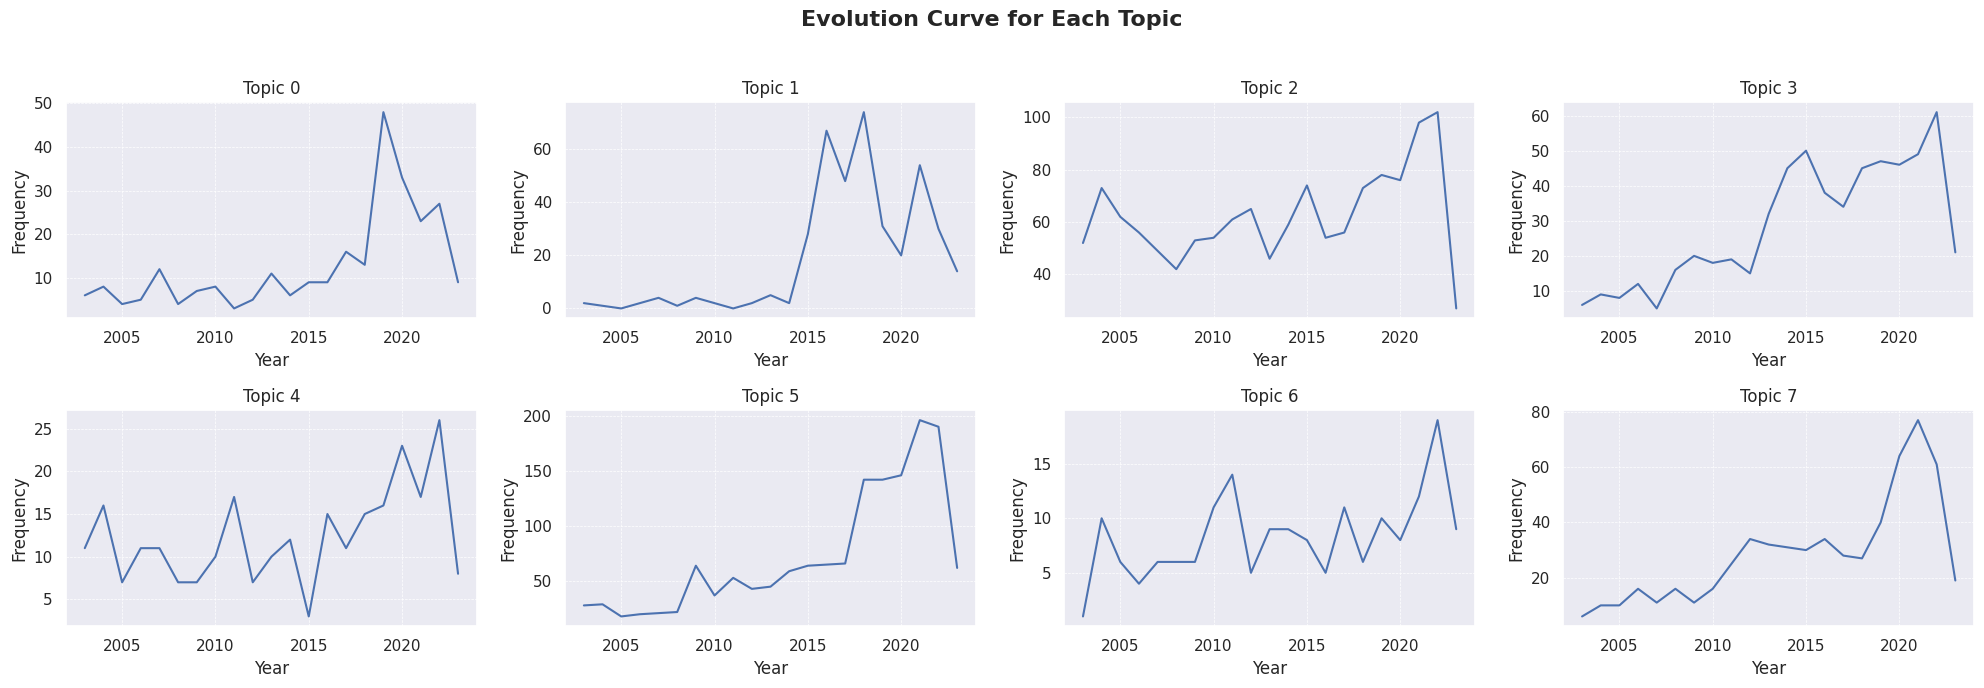

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the DataFrame from the CSV file (assuming it's stored as 'topic_counts_by_year.csv')
# Replace this line with your actual data if it's not in a CSV
#topic_counts_by_year = pd.read_csv('topic_counts_by_year.csv', index_col='Publication Year')

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Define the number of topics (make sure this matches your data)
n_topics = len(topic_counts_by_year.columns)

# Calculate the number of rows needed for subplots
n_rows = (n_topics + 3) // 4  # +4 for rounding up

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 3.5))

# Flatten the array to easily iterate over it
axes_flat = axes.flatten()

# Loop through each topic and plot its curve on a separate subplot
for i, topic in enumerate(topic_counts_by_year.columns):
    axes_flat[i].plot(
        topic_counts_by_year.index,
        topic_counts_by_year[topic]
    )
    axes_flat[i].set_title(f'Topic {topic}')
    axes_flat[i].set_xlabel('Year')
    axes_flat[i].set_ylabel('Frequency')
    axes_flat[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove extra subplots
for i in range(n_topics, len(axes_flat)):
    fig.delaxes(axes_flat[i])

# Add a main title for the entire figure
fig.suptitle('Evolution Curve for Each Topic', fontsize=16, fontweight='bold')

# Save the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the main title
plt.savefig(f'/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/topic_evolution_curves_subplot_ordered_patent.png', dpi=600)

# Show the figure
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Temporal Heatmaps: Display how topic proportions change over time.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


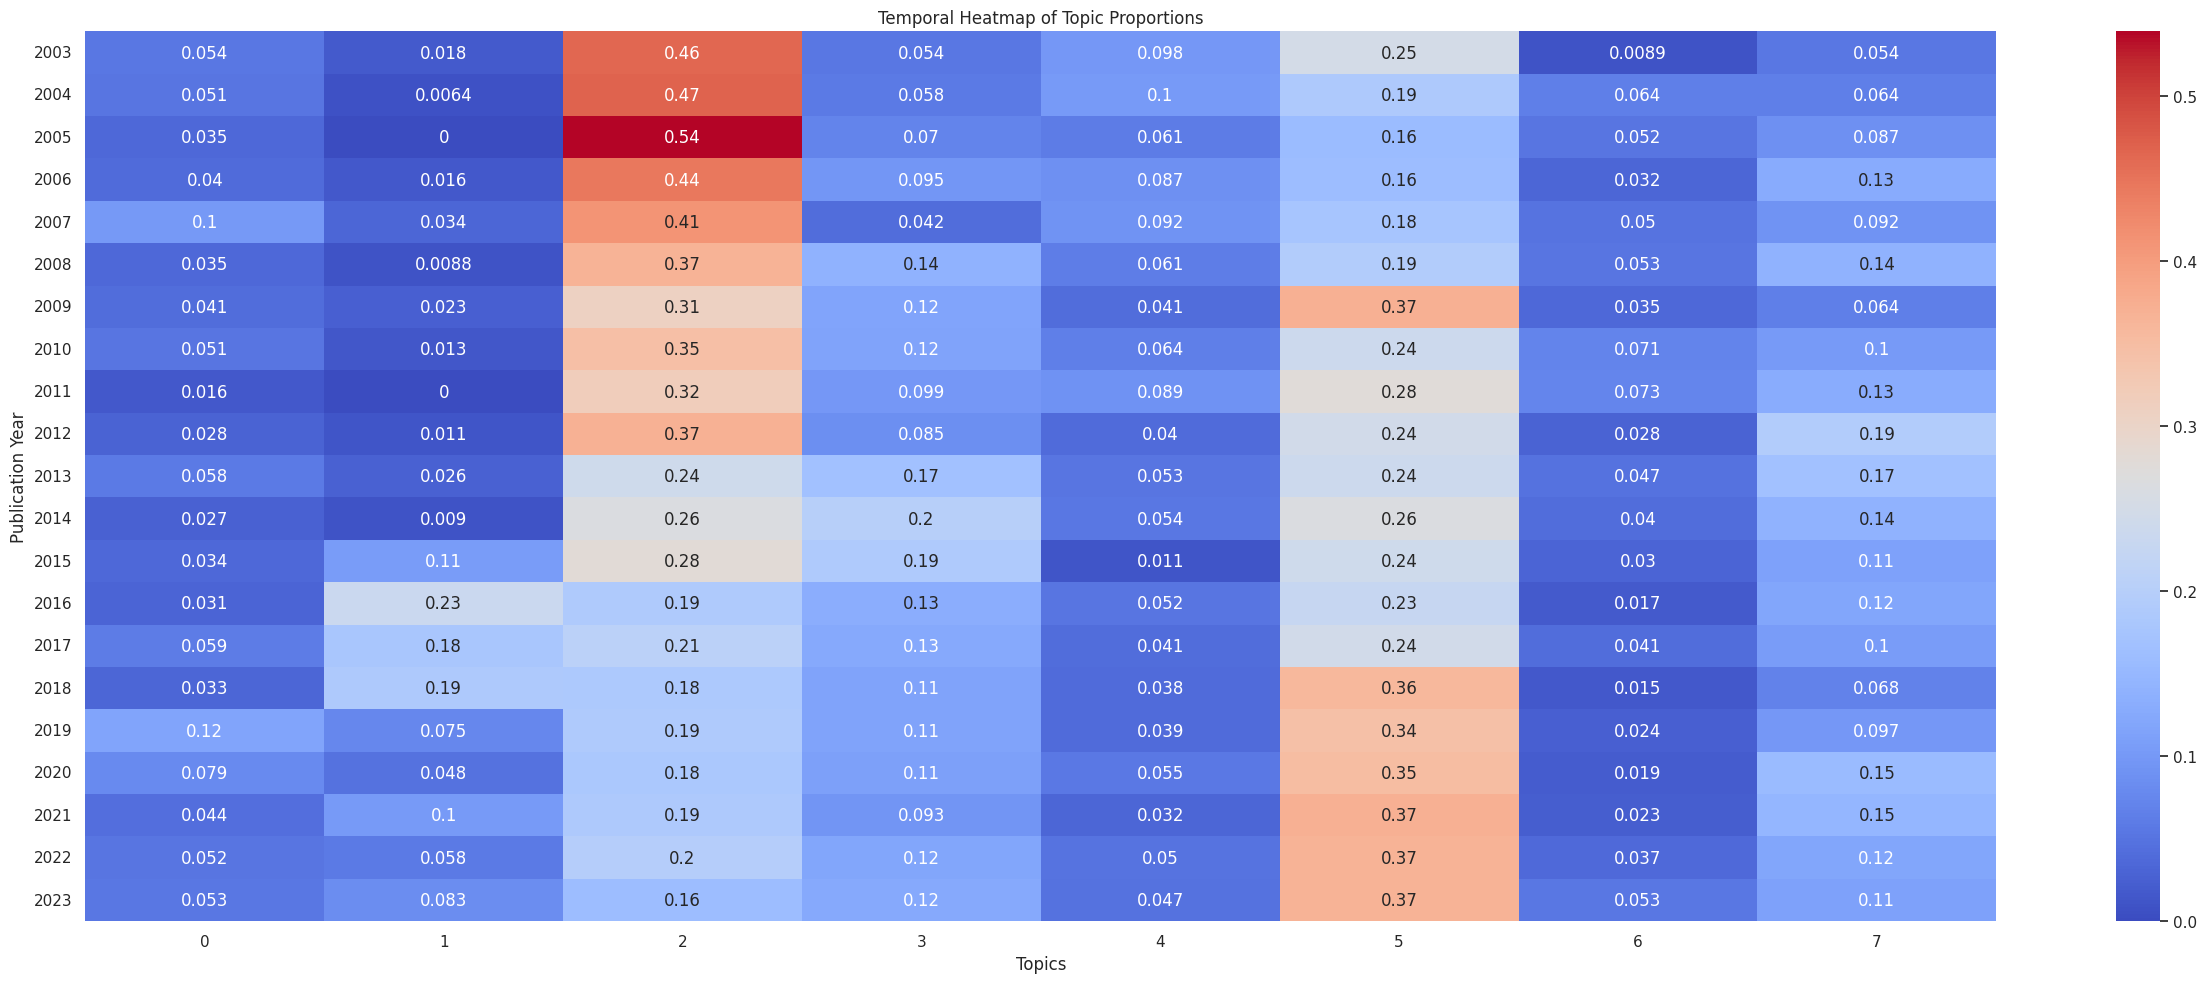

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assume you already have topic_counts_by_year DataFrame

# Remove the 'Total' row if it exists
if 'Total' in topic_counts_by_year.index:
    topic_counts_by_year = topic_counts_by_year.drop(index=['Total'])

# Sort columns by topic name
topic_counts_by_year = topic_counts_by_year.sort_index(axis=1)

# Calculate the total count for each year (row-wise sum)
total_counts_by_year = topic_counts_by_year.sum(axis=1)

# Normalize frequencies to get proportions
proportions_by_year = topic_counts_by_year.divide(total_counts_by_year, axis=0)

# Create the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(proportions_by_year.fillna(0), annot=True, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True)

# Add labels and title
plt.title('Temporal Heatmap of Topic Proportions')
plt.xlabel('Topics')
plt.ylabel('Publication Year')

# Save the figure
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/YORKU PROJECT/JUDE/BACTERIOPHAGE/temporal_heatmap_topic_proportions_patent.png")  # Save the plot to a PNG file

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
